# Generalized Linear Models

Fall 2022: Peter Ralph

https://uodsci.github.io/dsci345

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 8)
import numpy as np
import pandas as pd
from dsci345 import pretty

rng = np.random.default_rng()

$$\renewcommand{\P}{\mathbb{P}} \newcommand{\E}{\mathbb{E}} \newcommand{\var}{\text{var}} \newcommand{\sd}{\text{sd}} \newcommand{\cov}{\text{cov}} \newcommand{\cor}{\text{cor}}$$
This is here so we can use `\P` and `\E` and `\var` and `\cov` and `\cor` and `\sd` in LaTeX below.

# Linear models: recap

We've seen a few flavors of "linear model".
First, the 'standard':
$$\begin{aligned}
    Y &= Xb + \epsilon \\
    \epsilon &\sim \text{Normal}(\text{mean}=0, \text{sd}=\sigma) ,
\end{aligned}$$
which is equivalent to
$$\begin{aligned}
    Y &\sim \text{Normal}(\text{mean}= Xb, \text{sd}=\sigma) .
\end{aligned}$$

Robust:
$$\begin{aligned}
    Y &\sim \text{Cauchy}(\text{location}= Xb, \text{scale}=\sigma) .
\end{aligned}$$

And, in homework, Poisson:
$$\begin{aligned}
    Y &\sim \text{Poisson}(\text{mean}=\exp(Xb)) .
\end{aligned}$$

What are these "models" *for*?

- understanding how signal and noise combine in your data,
    and how to extract the information you want
    
- simulating data, to test methods and build intuition

- providing a framework to describe the data
    (to *fit* the model, e.g., by maximum likelihood)

- describing how good predictions based on a fitted model are likely to be

You could, for instance, decide your data come from a Poisson model
and yet still fit it by least squares
(i.e., maximum likelihood with a Normal model).
*But*: the "correct" model
(i.e., one that better describes the noise distribution)
should provide more accurate results.

## Generalizing

In each case, we said:

1. The *response*, $Y$, is random with some distribution,
2. whose *mean* is determined by a linear combination of the *predictors*, $X$.

## Ingredients

A *generalized linear model* has three ingredients:

1. a *response distribution* for $Y$ (the "family"),
2. a *linear predictor*, $Xb$, and
3. a *link function* $h( )$ connecting the linear predictor to the mean of the response,
    usually $h(\E[Y]) = Xb$.

For instance:
$$\begin{aligned}
    Y &\sim \text{Poisson}(\text{mean}=\exp(Xb)) 
\end{aligned}$$
is a Poisson GLM with a *log* link function
(since $\log(\E[Y]) = Xb$).

For instance:
$$\begin{aligned}
    Y &\sim \text{Normal}(\text{mean}= Xb, \text{sd}=\sigma) .
\end{aligned}$$
is a Normal GLM with an *identity* link function.

# Logistic models

Probably the most common GLM besides Normal is the "Binomial GLM with a logistic link",
i.e.:
$$\begin{aligned}
    Y_i &\sim \text{Binomial}(\text{size}=N_i, \text{prob}=\theta_i) \\
    \theta_i &= \frac{1}{1 + e^{-Xb}} .
\end{aligned}$$

Here $f(x) = 1/(1 + e^{-x})$ is the *logistic function*,
which takes the linear predictor (which can be any value)
and gives us back a number between 0 and 1:

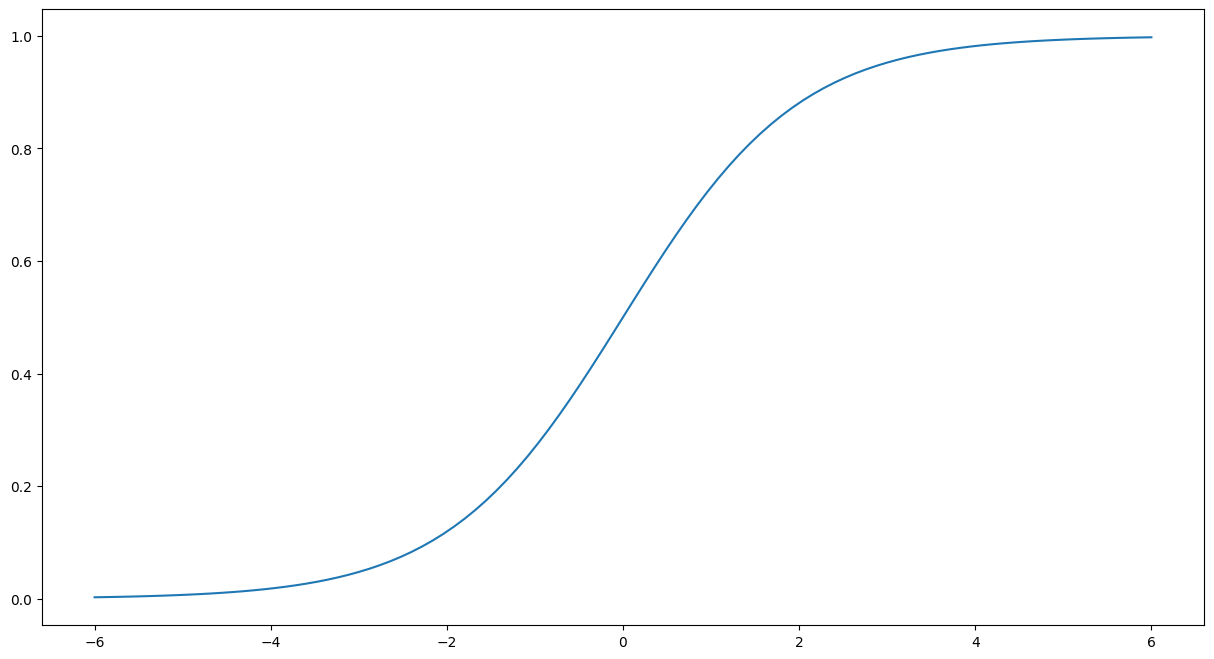

In [70]:
xx = np.linspace(-6, 6, 101)
plt.plot(xx, 1/(1 + np.exp(-xx)));

## Example: keep your head down

Taller dandelion flowers spread their seeds farther...
but are also more likely to be eaten.
We survey a field before and after a herd of cows come through,
and determine that the chance that a dandelion that is $x$ inches high is
$$
    p(x) = \frac{1}{1 + e^{-(x - 5)}} .
$$

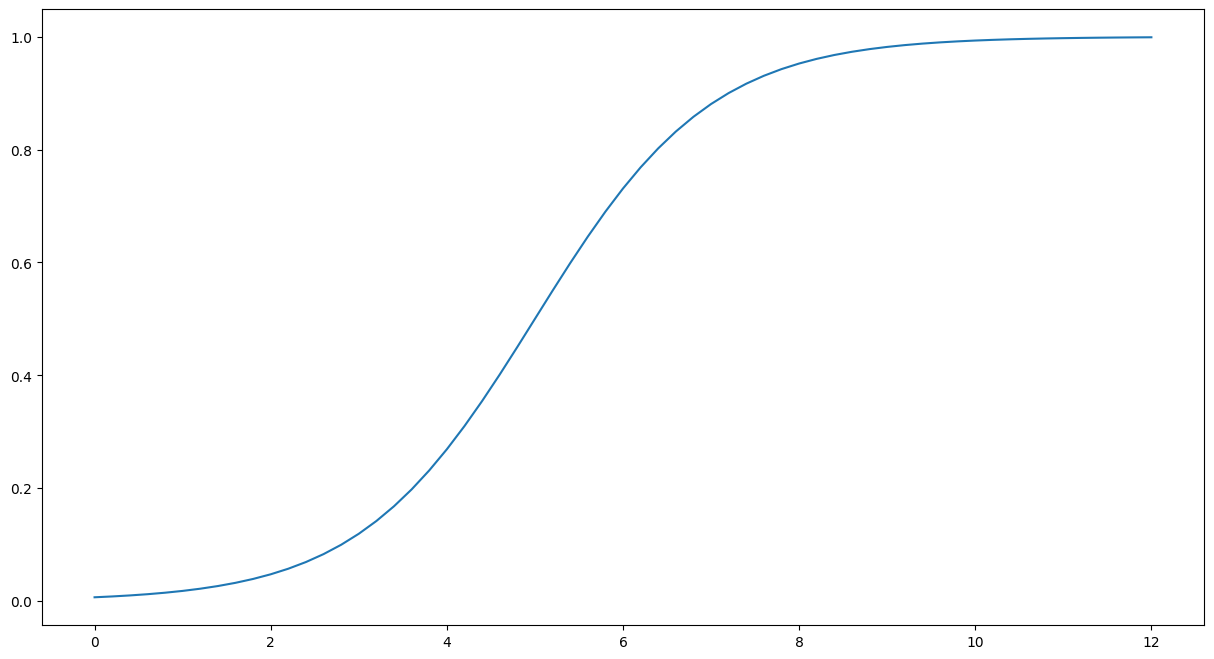

In [95]:
xvals = np.linspace(0, 12, 61)
pvals = 1/(1 + np.exp(-(xvals - 5)))
plt.plot(xvals, pvals);

How might we determine this?
Here's some hypothetical data: circles are uneaten, x's are eaten,
along with the theoretical curve,
as well as the proportion eaten in one inch height bins:

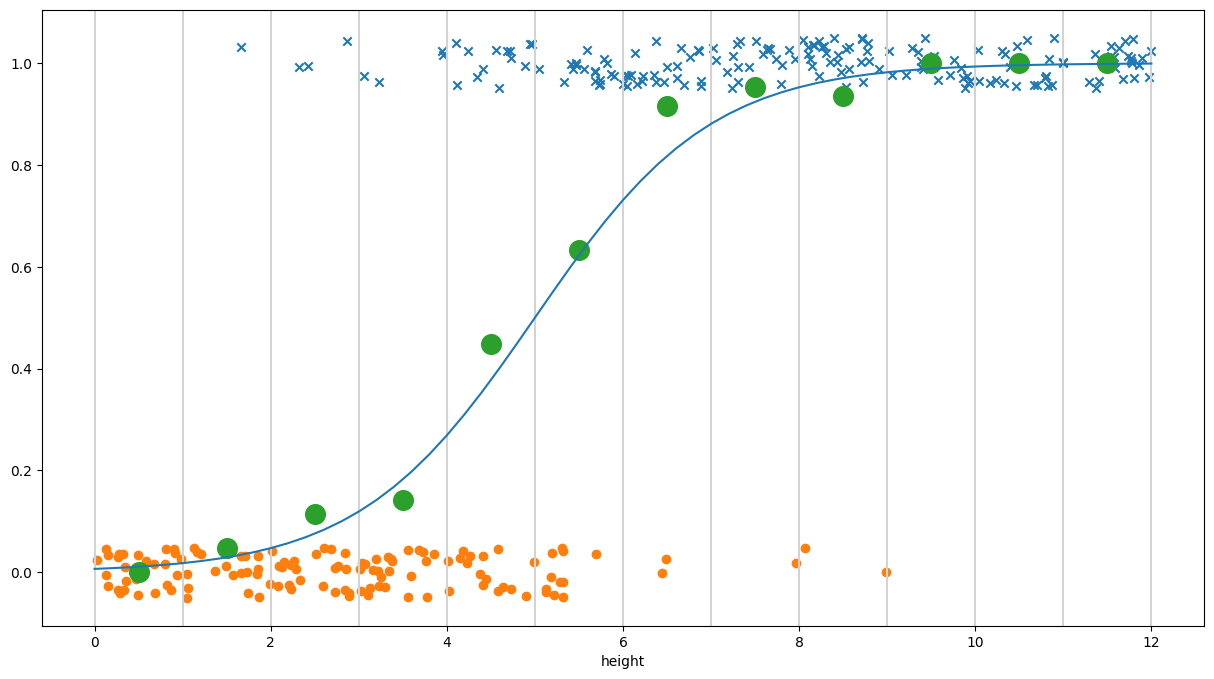

In [96]:
n = 300
x = rng.uniform(low=0, high=12, size=n)
eaten = (rng.random(n) < 1/(1 + np.exp(-(x-5))))
fig, ax = plt.subplots()
[ax.axvline(k, c='lightgrey') for k in range(13)];
ax.scatter(x[eaten], 1.0 + rng.uniform(-.05, .05, np.sum(eaten)), marker = "x")
ax.scatter(x[~eaten], rng.uniform(-.05, .05, np.sum(~eaten)), marker = "o")
ax.plot(xvals, pvals)
ax.set_xlabel("height"); ax.set_label("eaten?")
props = [np.mean(eaten[np.floor(x) == k]) for k in range(12)]
ax.scatter(np.arange(12) + 0.5, props, s=200);

## Example: incidence

Let's build a model of lung cancer incidence,
based loosely on the results of [Tammemagi et al 2011](https://doi.org/10.1093/jnci/djr173).
Suppose we have a study of smokers aged 50-80 years old,
for whom we find out (a) their age,
(b) how many "pack-years" did they smoke during their life (which ranges from 0 to 250 but mostly less than 50),
and (c) whether they develop lung cancer over the 10-year study.
The overall cancer rate is about 7% (*tangential note:* it is about 30x lower in non-smokers).
Suppose that the probability of developing lung cancer
of someone of age $a$ and a total number of pack-years smoked $s$ is
$$\begin{aligned}
    p(a, s) = \frac{1}{1 + \exp(-(4.1 + .02 a + .01 s))} .
\end{aligned}$$
Incidence goes up with age and pack-years.

Here is a visual depiction of the model:

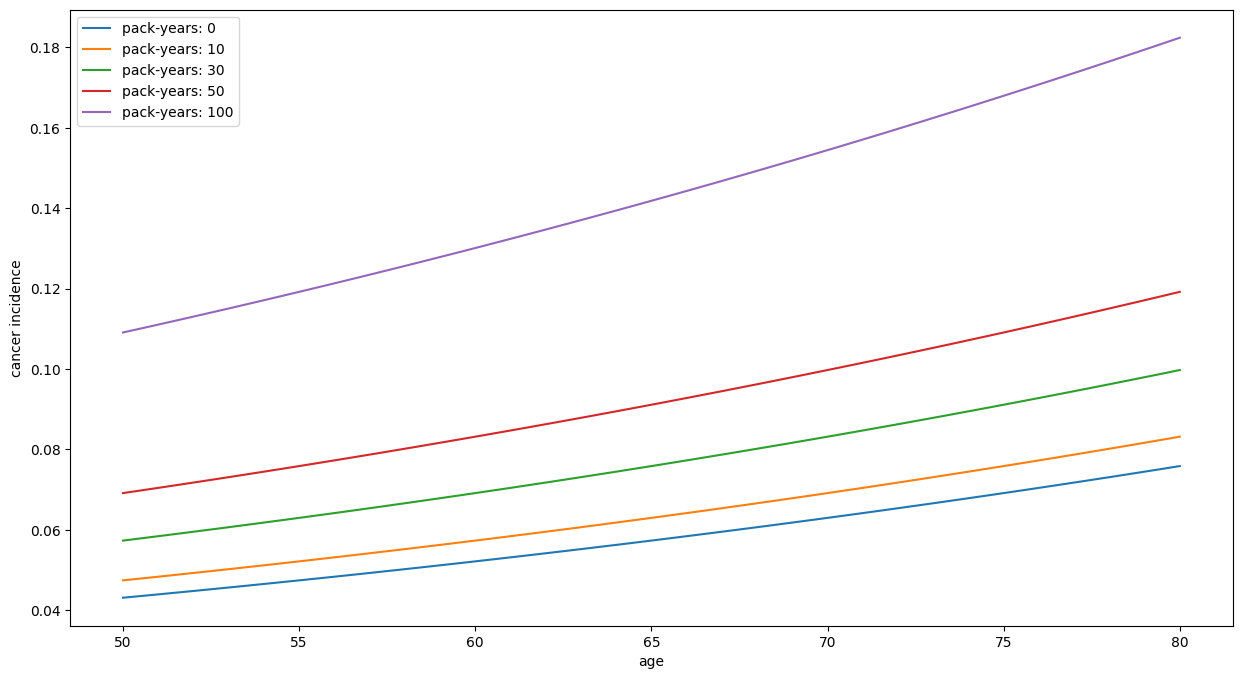

In [38]:
aa = np.linspace(50, 80, 101)
for s in [0, 10, 30, 50, 100]:
    plt.plot(aa, 1/(1 + np.exp(-(-4.1 + .02 * aa + .01 * s))), label=f"pack-years: {s}")
plt.xlabel("age"); plt.ylabel("cancer incidence")
plt.legend();

Our plan:

1. Simulate 10,000 data points (people) from this model.
2. Fit the model.
3. See how close we get to the true parameters.

First, let's pick distributions for *age* and *pack-years*:

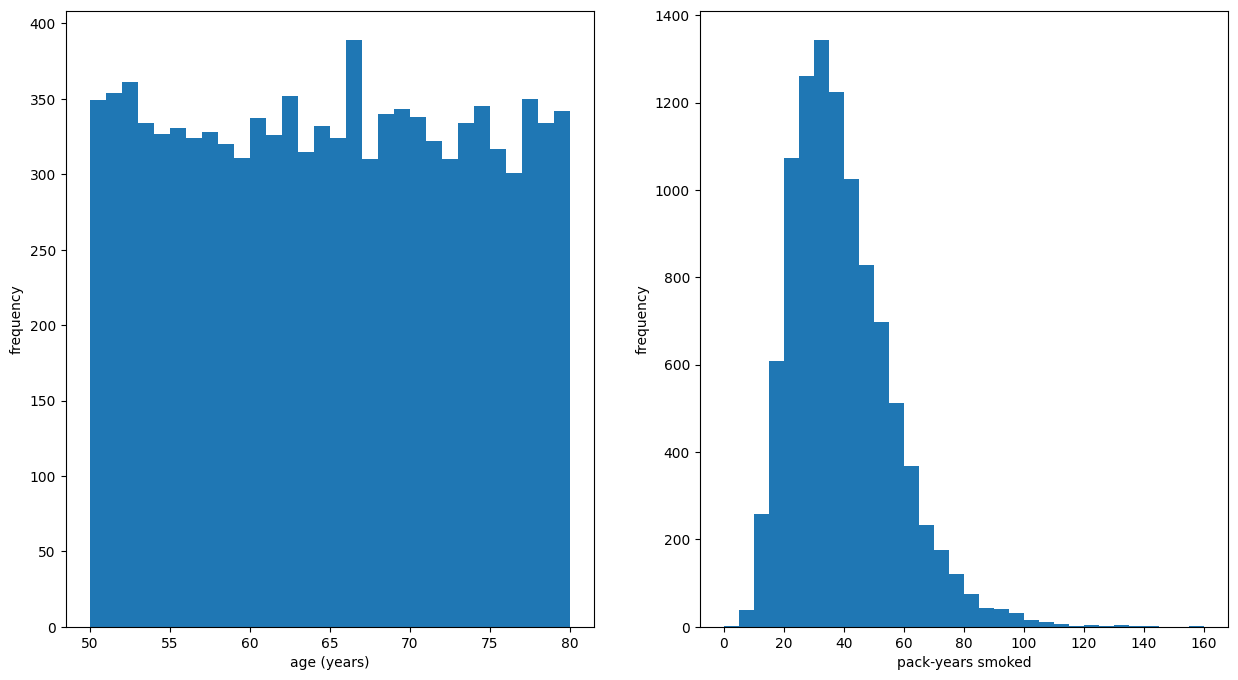

In [133]:
n = 10_000
age = np.round(rng.uniform(low=50, high=80, size=n), 1)
pack_years = np.round(rng.gamma(shape=6, scale=0.1*age), 0)

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.hist(age, bins=pretty(age, 40))
ax0.set_xlabel("age (years)"); ax0.set_ylabel("frequency")
ax1.hist(pack_years, bins=pretty(pack_years, 40))
ax1.set_xlabel("pack-years smoked"); ax1.set_ylabel("frequency");

The joint distribution:

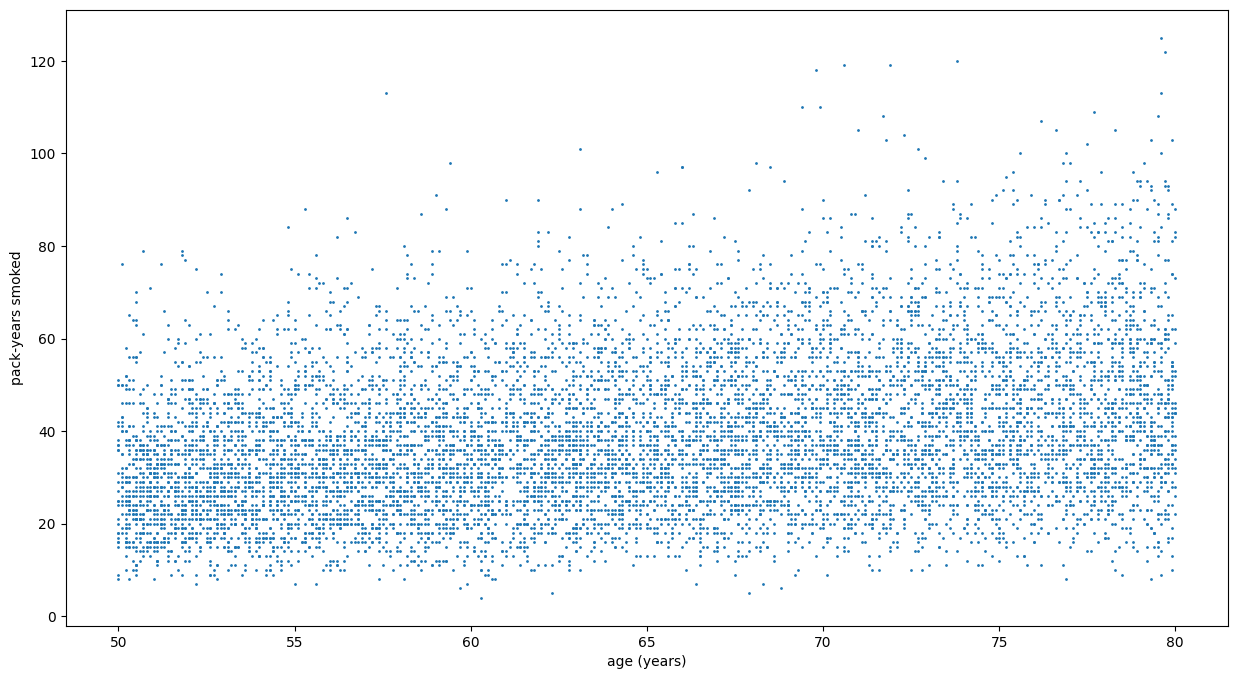

In [103]:
plt.scatter(age, pack_years, s=1)
plt.xlabel("age (years)"); plt.ylabel("pack-years smoked");

Now, let's decide whether they develop cancer
based on age and years smoked:

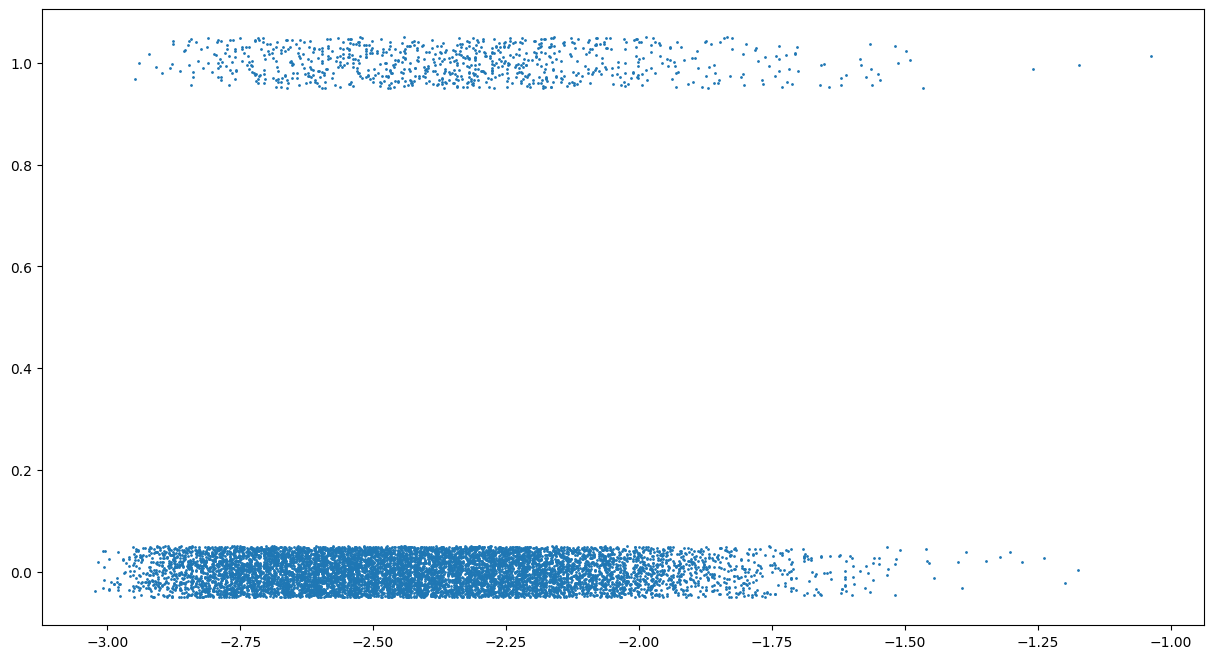

In [134]:
theta = -4.1 + .02 * age + .01 * pack_years
prob_cancer =  1/(1 + np.exp(-theta))
cancer = rng.binomial(n=1, p=prob_cancer)

plt.scatter(theta, cancer + rng.uniform(low=-.05, high=.05, size=n), s=1);

To fit the model we could use our old friend `scipy.optimize.minimize`,
but instead we'll use [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression):

In [131]:
from sklearn.linear_model import LogisticRegression
X = np.vstack([age, pack_years]).T
lfit = LogisticRegression(penalty='none').fit(X, cancer)
b_age, b_py = lfit.coef_[0]
print(f"The linear predictor is {lfit.intercept_[0]:.3} + {b_age:.3} * age + {b_py:.3} * pack_years .")

The linear predictor is -4.06 + 0.0195 * age + 0.00991 * pack_years .


Here's the fit:

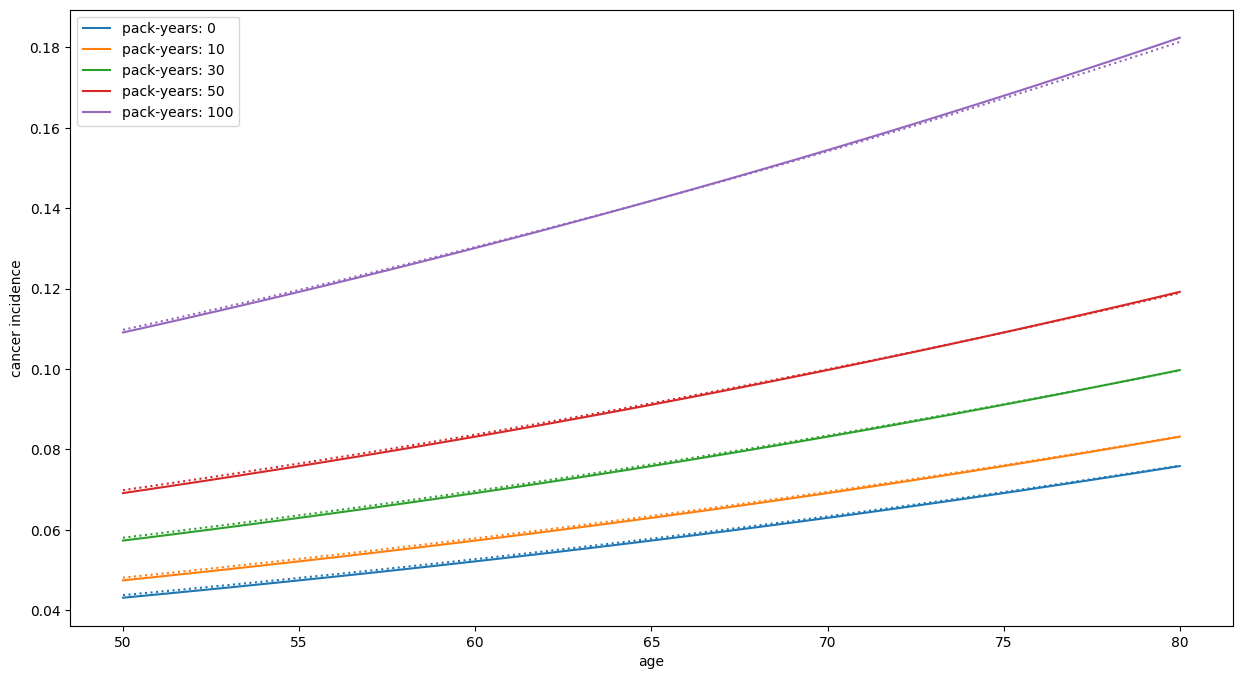

In [135]:
aa = np.linspace(50, 80, 101)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for s, c in zip([0, 10, 30, 50, 100], colors):
    plt.plot(aa, 1/(1 + np.exp(-(-4.1 + .02 * aa + .01 * s))), label=f"pack-years: {s}", c=c)
    plt.plot(aa, lfit.predict_proba(np.vstack([aa, np.repeat(s, len(aa))]).T)[:,1], linestyle=":", c=c)
plt.xlabel("age"); plt.ylabel("cancer incidence")
plt.legend();

In [124]:
list(zip(range(3), range(5)))

[(0, 0), (1, 1), (2, 2)]